### Identify cause of convection

Next: look into to what extent offshore CDW properties are changing causing the problems or whether CDW transport/supply changes to the Weddell Sea could explain it

- look at U, V horizontal heat transport estimates
- look at T-S diagram endmembers

Is the cooling of the WDW (warm deep water) layer just a result of the convection that happens or does it precede it?

In [1]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import weddell_convect, ross_convect

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mesh= f'{base_dir}bathymetry/mesh_mask-20240305.nc'

## Vertical heat diffusivities

In [3]:
# regions:
weddell_basin      = {'x': slice(950, 1150, None), 'y': slice(295, 360, None)} # very similar to weddell convect but withwout shelf edge
weddell_west_shelf = {'x': slice(918, 967, None), 'y': slice(245, 310, None)}
weddell_overall    = {'x': slice(850, 1200, None), 'y': slice(50, -1, None)}

Look at what happens just at the shelfbreak:

In [4]:
def extract_region_var(run_dir, var_name, region, file_slice=(0,None), file_type='grid_T'):
    if file_type=='grid_W': 
        name_remapping1 = {'nav_lev':'depthw'}
        mask = 'tmask'
    elif file_type=='grid_T':
        name_remapping1 = {'nav_lev':'deptht'}
        mask = 'tmask'
    elif file_type=='grid_U': mask = 'umask'; name_remapping1={'nav_lev':'depthu'};
    elif file_type=='grid_V': mask = 'vmask'; name_remapping1={'nav_lev':'depthv'};

    nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0, x=region['x'], y=region['y']).rename(name_remapping1)
    
    files = glob.glob(f'{run_dir}eANT025*{file_type}*')[file_slice[0]:file_slice[1]]

    area_name='area'
    if file_type=='grid_T': area_name = 'area_grid_T'; name_remapping2 = {'area_grid_T':'area', 'x_grid_T':'x', 'y_grid_T':'y'}
    else: name_remapping2={} 
        
    kwags={'preprocess':lambda ds: ds[[var_name, area_name, 'time_counter']], 'chunks':'auto'}
    nemo_ds    = xr.open_mfdataset(files, **kwags).rename(name_remapping2)
    nemo_ds    = nemo_ds.isel(x=region['x'], y=region['y']) 
    area_ocean = nemo_ds['area'].isel(time_counter=0).expand_dims({name_remapping1['nav_lev']:nemo_ds[name_remapping1['nav_lev']]})
    area_ocean = xr.where(nemo_mesh_ds[mask].values==0, np.nan, area_ocean)
    var_ocean  = xr.where(nemo_mesh_ds[mask].values==0, np.nan, nemo_ds[var_name])
    var_ocean  = xr.where(var_ocean==0, np.nan, var_ocean)

    region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
    region_var = xr.where(region_var==0, np.nan, region_var)

    return region_var, var_ocean

In [5]:
def plot_hovmoeller(region_var, ylim=(1600, 0), vmin=0, vmax=1e-2, cmap=cmocean.cm.haline, grid_type='T'):

    if grid_type=='T': depth='deptht'
    elif grid_type=='W': depth='depthw'
    elif grid_type=='U': depth='depthu'
    elif grid_type=='V': depth='depthv'

    fig, ax = plt.subplots(1,1, figsize=(18,5))
    xx, yy = np.meshgrid(region_var.time_counter, region_var[depth])
    
    cb = ax.pcolormesh(xx.transpose(), yy.transpose(), region_var, vmin=vmin, vmax=vmax, cmap=cmap, norm=colors.LogNorm())
    
    fig.colorbar(cb, ax=ax)
    ax.set_ylim(ylim[0], ylim[1])

    return fig, ax

In [6]:
run_dir = f'{base_dir}output/ERA5_test6_highres/files/'
time_slice=(90,240)#-1)

region = weddell_overall

# weddell_vdiff, vdiff = extract_region_var(run_dir, 'difvho' , region, file_slice=time_slice, file_type='grid_W')
weddell_vdiff, vdiff = extract_region_var(run_dir, 'difvho' , region, file_slice=time_slice, file_type='grid_W')
# weddell_Uvel,  Uvel  = extract_region_var(run_dir, 'uo'     , region, file_slice=time_slice, file_type='grid_U')
# weddell_Vvel,  Vvel  = extract_region_var(run_dir, 'vo'     , region, file_slice=time_slice, file_type='grid_V')
# weddell_T, T         = extract_region_var(run_dir, 'thetao' , region, file_slice=time_slice, file_type='grid_T')
# weddell_S, S         = extract_region_var(run_dir, 'so'     , region, file_slice=time_slice, file_type='grid_T')

In [9]:
# weddell_basin_shear = ((weddell_basin_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2) + \
                       # (weddell_basin_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2))
# weddell_shelf_shear = ((weddell_shelf_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2) + \
#                        (weddell_shelf_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2))

# weddell_basin_rho = gsw.density.rho(weddell_basin_S, weddell_basin_T, weddell_basin_T.deptht) # nemo_mesh_ds.deptht
# weddell_basin_N2  = -9.81*1e-3*weddell_basin_rho.diff(dim='deptht')
weddell_rho = gsw.density.rho(weddell_S, weddell_T, weddell_T.deptht) # nemo_mesh_ds.deptht
weddell_N2  = -9.81*1e-3*weddell_rho.diff(dim='deptht')

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


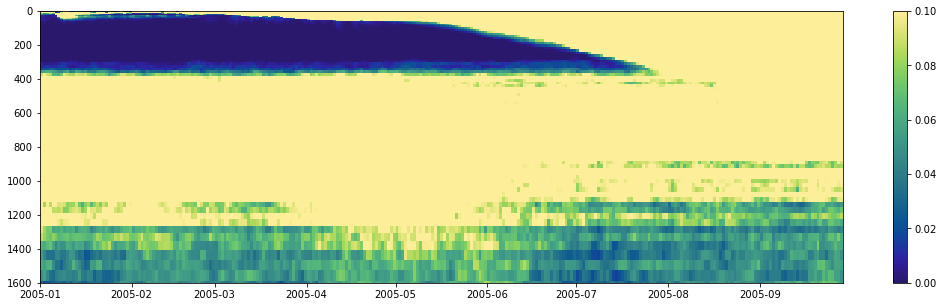

In [8]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_vdiff, grid_type='W', vmin=0, vmax=1e-1)

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


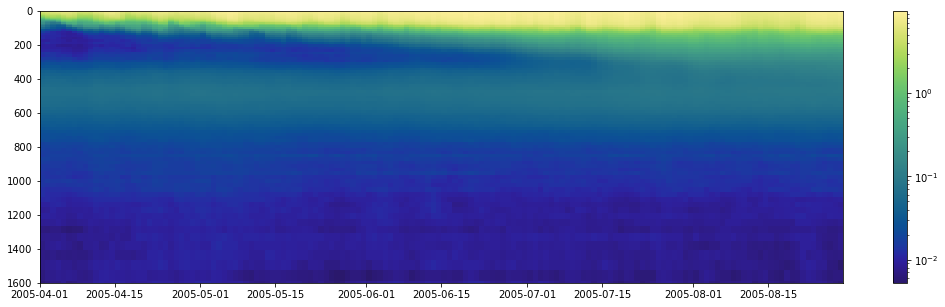

In [8]:
fig1, ax1 = plot_hovmoeller(weddell_vdiff, grid_type='W', vmin=None, vmax=None)#, vmin=0, vmax=1e-2)

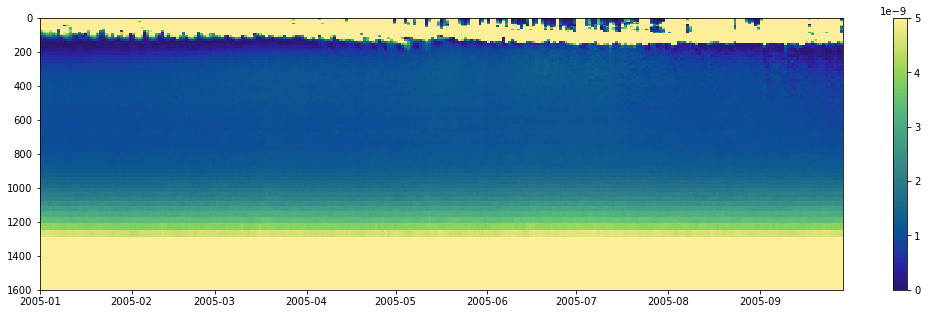

In [10]:
fig1, ax1 = plot_hovmoeller(weddell_basin_shear, grid_type='T', vmin=0, vmax=5e-9)

Or is the strong shear at the shelf break depth a consequence of the way I've calculated vertical shear? 

weddell_shelf_shear = ((weddell_shelf_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2) + \
                       (weddell_shelf_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2))

In [8]:
Uvel_shelf = weddell_shelf_Uvel.diff(dim='depthu').rename({'depthu':'deptht'})**2 
Vvel_shelf = weddell_shelf_Vvel.diff(dim='depthv').rename({'depthv':'deptht'})**2

In [31]:
Uvel_diff = Uvel.diff(dim='depthu').rename({'depthu':'deptht'})
Vvel_diff = Vvel.diff(dim='depthv').rename({'depthv':'deptht'})

In [98]:
weddell_shelf_rho = gsw.density.rho(S, T, T.deptht)

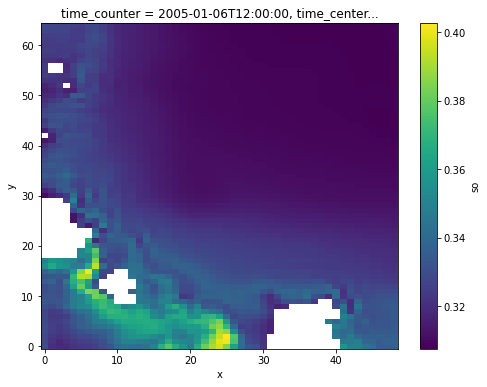

In [89]:
a = (weddell_shelf_rho).isel(time_counter=5, deptht=40)
b = (weddell_shelf_rho).isel(time_counter=5, deptht=44)
(b-a).plot(figsize=(8,6))

Could consider shortening the time step in case it's caused by instabilities

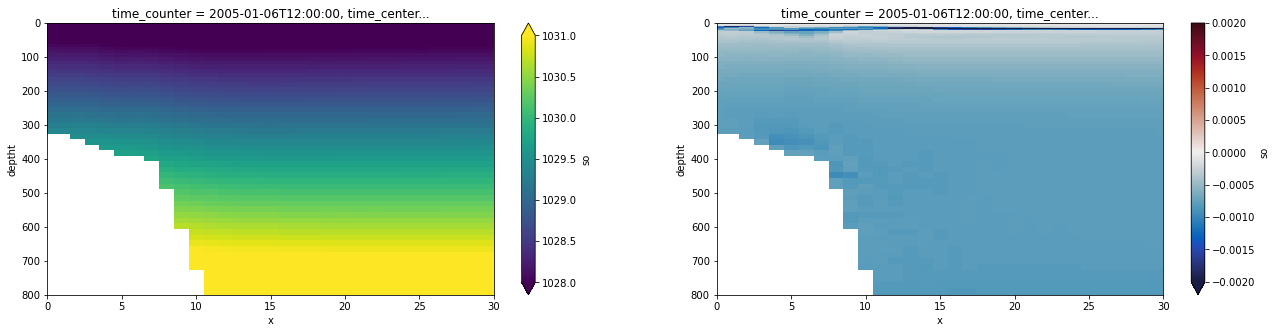

In [68]:
fig, ax = plt.subplots(1,2, figsize=(22, 5))
weddell_shelf_rho.isel(time_counter=5, y=23).plot(ax=ax[0], ylim=(800,0), xlim=(0,30), vmin=1028, vmax=1031)
(-9.81*1e-3*weddell_shelf_rho.diff(dim='deptht')).isel(time_counter=5, y=23).plot(ax=ax[1], ylim=(800,0), xlim=(0,30), 
                                                                          vmin=-2e-3, vmax=2e-3, cmap=cmocean.cm.balance)

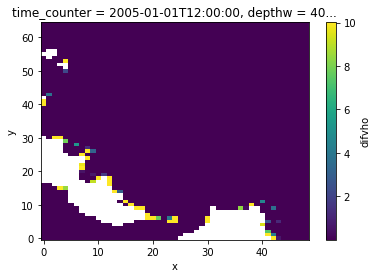

In [104]:
vdiff.isel(time_counter=0, depthw=45).plot()

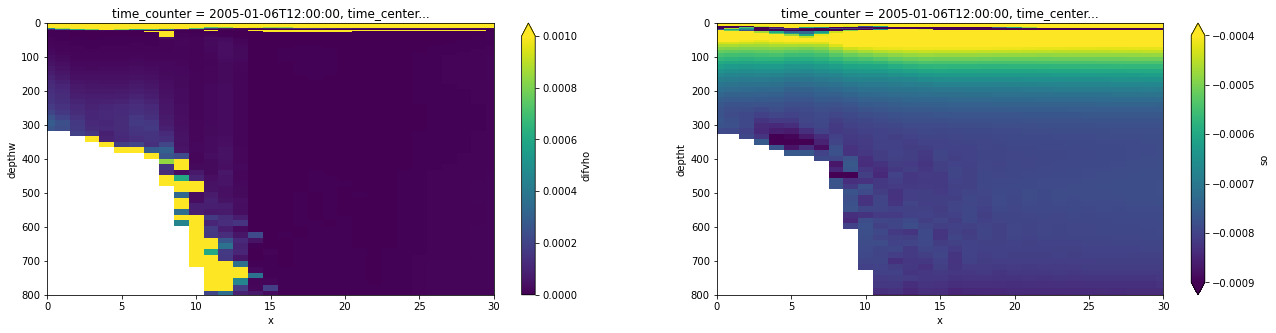

In [120]:
fig, ax = plt.subplots(1,2, figsize=(22, 5))
vdiff.isel(time_counter=5, y=23).plot(ax=ax[0], ylim=(800,0), xlim=(0,30), vmin=0, vmax=1e-3)
(-9.81*1e-3*weddell_shelf_rho.diff(dim='deptht')).isel(time_counter=5, y=23).plot(ax=ax[1], ylim=(800,0), xlim=(0,30), 
                                                                          vmin=-9e-4, vmax=-4e-4)

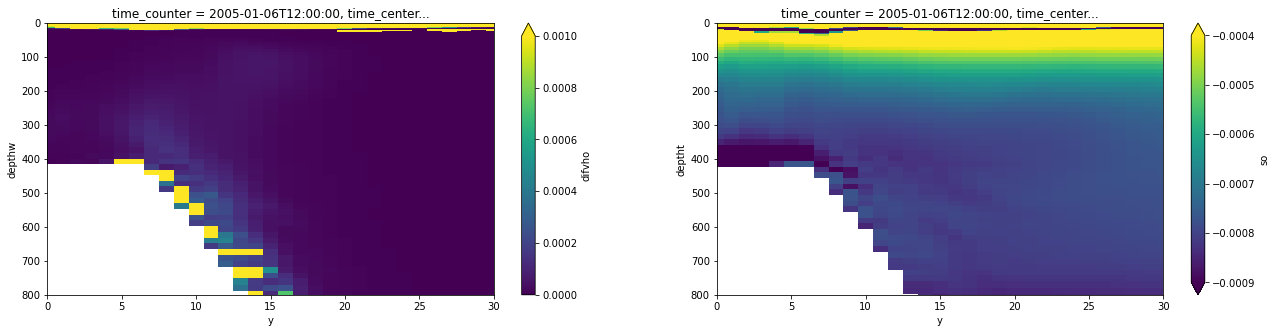

In [121]:
fig, ax = plt.subplots(1,2, figsize=(22, 5))
vdiff.isel(time_counter=5, x=23).plot(ax=ax[0], ylim=(800,0), xlim=(0,30), vmin=0, vmax=1e-3)
(-9.81*1e-3*weddell_shelf_rho.diff(dim='deptht')).isel(time_counter=5, x=23).plot(ax=ax[1], ylim=(800,0), xlim=(0,30), 
                                                                          vmin=-9e-4, vmax=-4e-4)

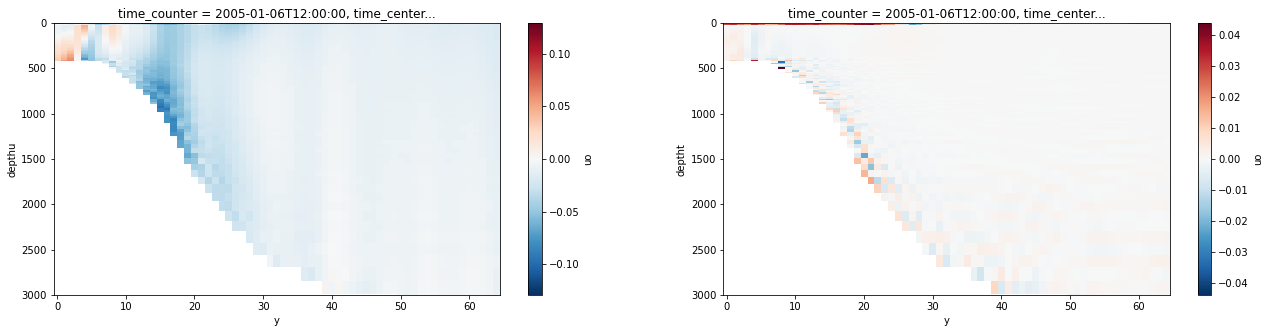

In [49]:
fig, ax = plt.subplots(1,2, figsize=(22, 5))
Uvel.isel(time_counter=5, x=23).plot(ax=ax[0], ylim=(3000, 0))
Uvel_diff.isel(time_counter=5, x=23).plot(ax=ax[1], ylim=(3000, 0))

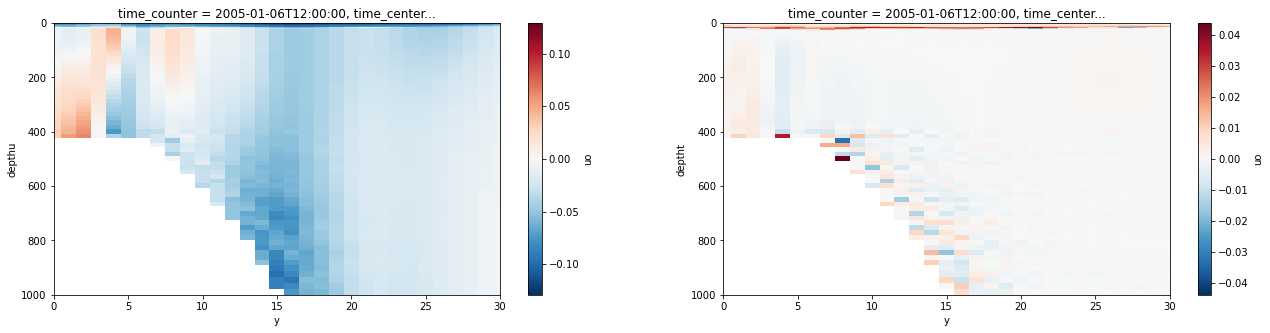

In [52]:
fig, ax = plt.subplots(1,2, figsize=(22, 5))
Uvel.isel(time_counter=5, x=23).plot(ax=ax[0], ylim=(1000,0), xlim=(0,30))
Uvel_diff.isel(time_counter=5, x=23).plot(ax=ax[1], ylim=(1000,0), xlim=(0,30))

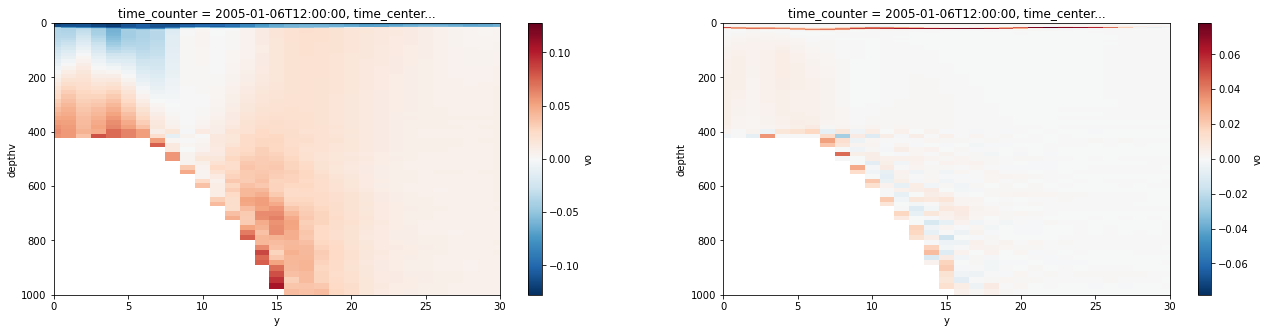

In [53]:
fig, ax = plt.subplots(1,2, figsize=(22, 5))
Vvel.isel(time_counter=5, x=23).plot(ax=ax[0], ylim=(1000,0), xlim=(0,30))
Vvel_diff.isel(time_counter=5, x=23).plot(ax=ax[1], ylim=(1000,0), xlim=(0,30))

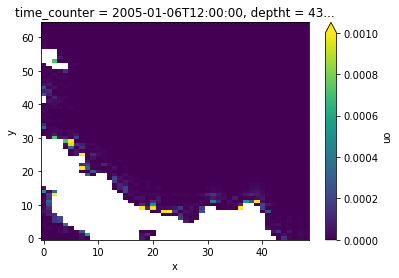

In [40]:
(Uvel_diff.isel(time_counter=5, deptht=45)**2).plot(vmin=0, vmax=1e-3)

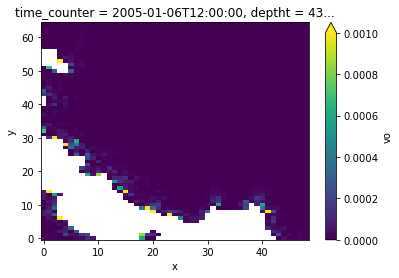

In [43]:
(Vvel_diff.isel(time_counter=5, deptht=45)**2).plot(vmin=0, vmax=1e-3)

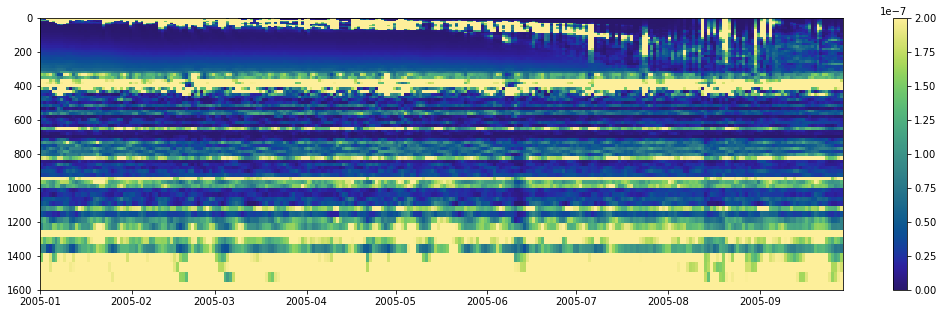

In [36]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_shear, grid_type='T', vmin=0, vmax=2e-7)

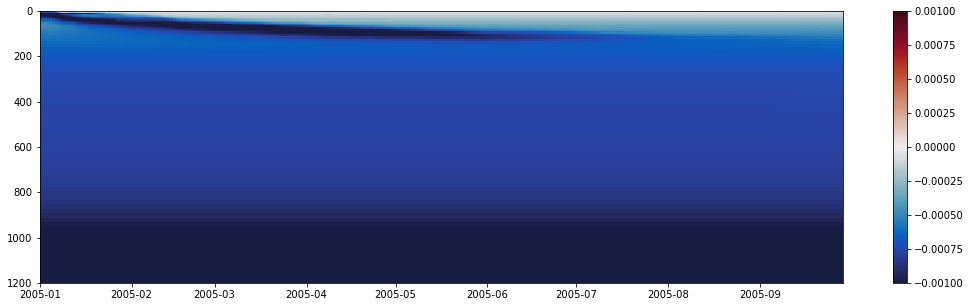

In [12]:
fig1, ax1 = plot_hovmoeller(weddell_basin_N2, grid_type='T', vmin=-1e-3, vmax=1e-3, ylim=(1200,0), cmap=cmocean.cm.balance)

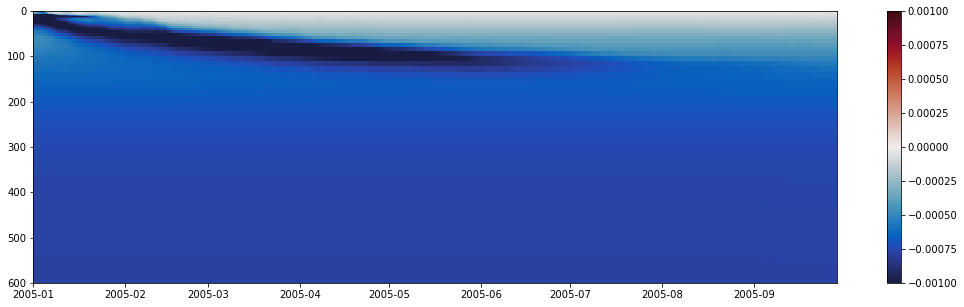

In [13]:
fig1, ax1 = plot_hovmoeller(weddell_basin_N2, grid_type='T', vmin=-1e-3, vmax=1e-3, ylim=(600,0), cmap=cmocean.cm.balance)

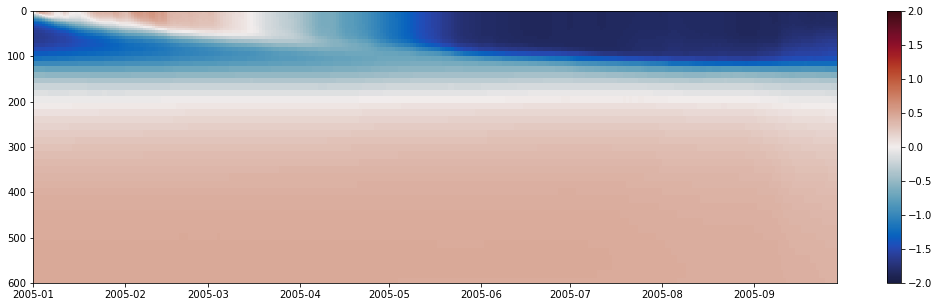

In [14]:
fig1, ax1 = plot_hovmoeller(weddell_basin_T, grid_type='T', vmin=-2, vmax=2, ylim=(600,0), cmap=cmocean.cm.balance)

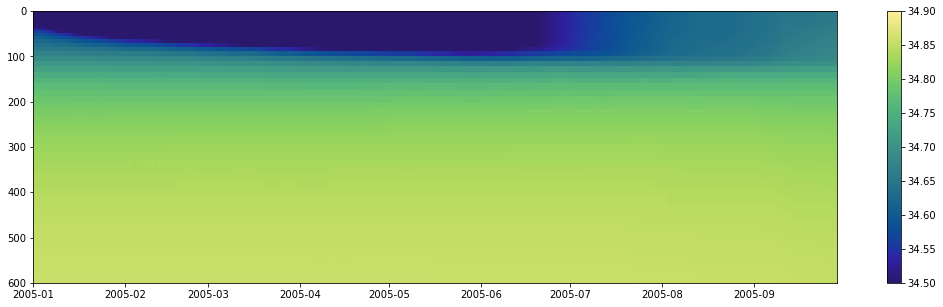

In [15]:
fig1, ax1 = plot_hovmoeller(weddell_basin_S, grid_type='T', vmin=34.5, vmax=34.9, ylim=(600,0))

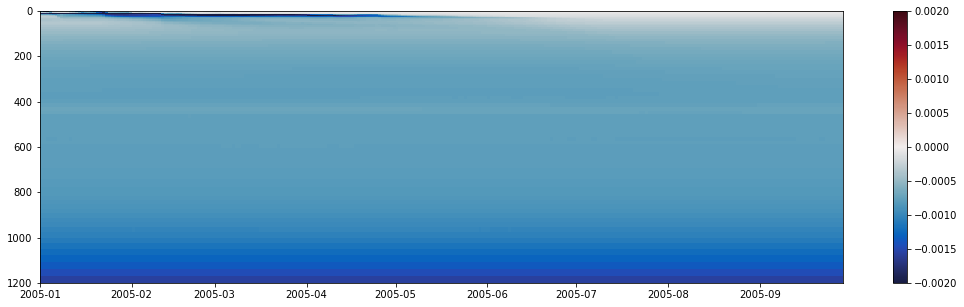

In [16]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_N2, grid_type='T', vmin=-2e-3, vmax=2e-3, ylim=(1200,0), cmap=cmocean.cm.balance)

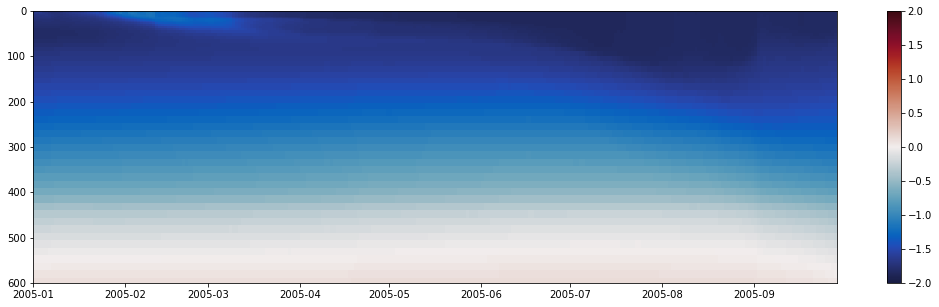

In [17]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_T, grid_type='T', vmin=-2, vmax=2, ylim=(600,0), cmap=cmocean.cm.balance)

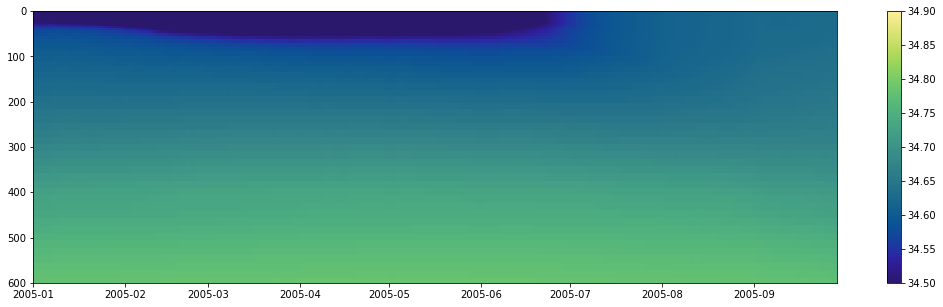

In [18]:
fig1, ax1 = plot_hovmoeller(weddell_shelf_S, grid_type='T', vmin=34.5, vmax=34.9, ylim=(600,0))

plot vertical diffusivity map at 600 m for early may to see whether there are particular regions where this feature mainly shows up

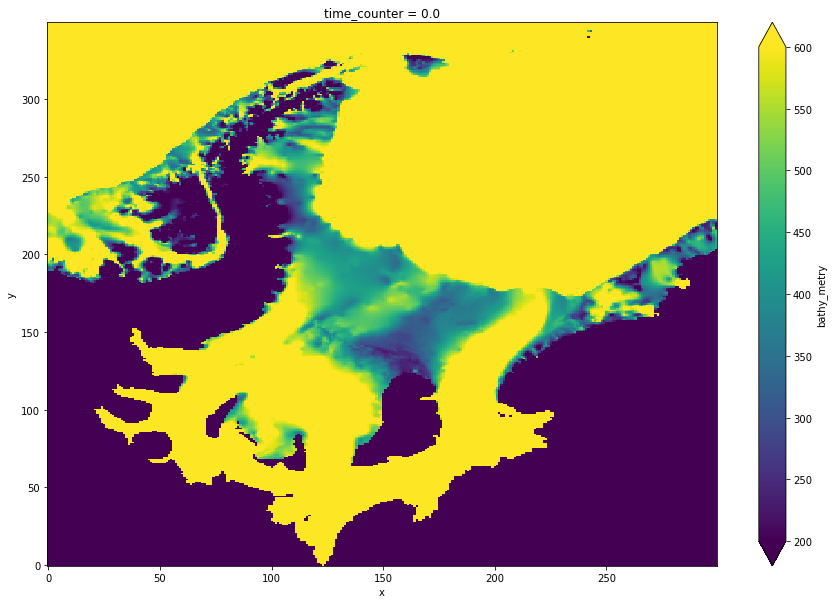

In [14]:
nemo_mesh_ds = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0)
nemo_mesh_ds.bathy_metry.isel(x=slice(800,1100), y=slice(50,400)).plot(figsize=(15,10), vmin=200, vmax=600)

In [ ]:
run_dir = f'{base_dir}output/ERA5_test6_highres/files/'
file = glob.glob(f'{run_dir}eANT025*grid_W*')[50]
mayW = xr.open_dataset(file).squeeze()
mesh = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0)
diff = xr.where(mesh.tmask.values==0, np.nan, mayW.difvho)

In [ ]:
diff.isel(depthw=45).plot(figsize=(18,10), xlim=(850, 1200), ylim=(100, 400), vmin=0, vmax=1)

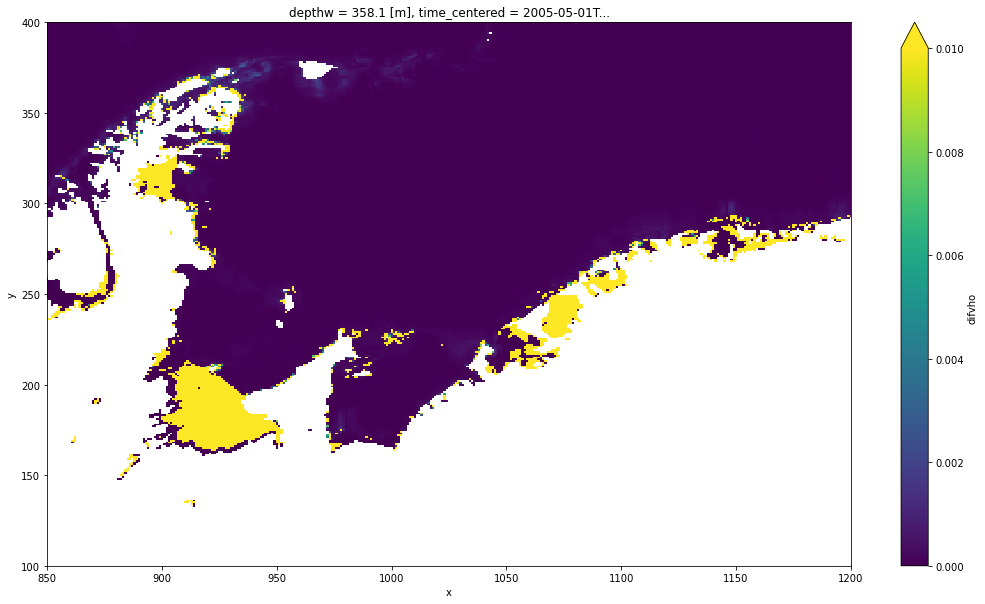

In [20]:
diff.isel(depthw=42).plot(figsize=(18,10), xlim=(850, 1200), ylim=(100, 400), vmin=0, vmax=1e-2)

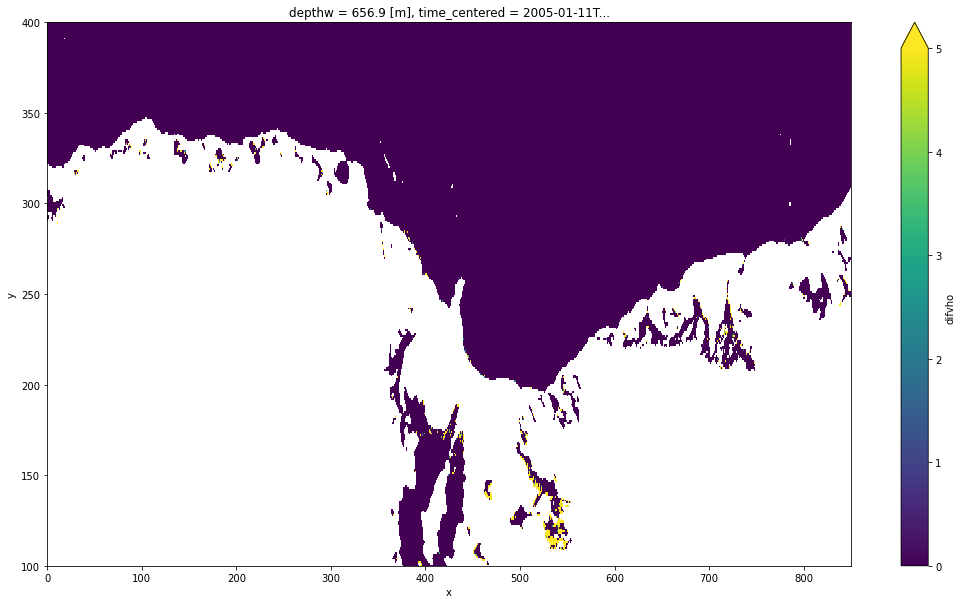

In [33]:
diff.isel(depthw=60).plot(figsize=(18,10), xlim=(0, 850), ylim=(100, 400), vmin=0, vmax=5)

# CDW changes:
- look at U, V horizontal heat transport estimates
- look at T-S diagram endmembers

In [11]:
rho = gsw.density.rho(S, T, T.deptht) # nemo_mesh_ds.deptht
N2  = -9.81*1e-3*rho.diff(dim='deptht')

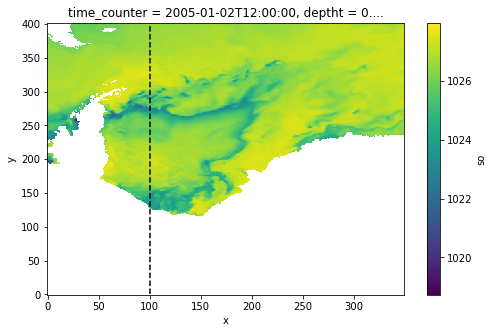

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
rho.isel(time_counter=1, deptht=0).plot(ax=ax)
ax.plot([100, 100], [0, 400], '--k')

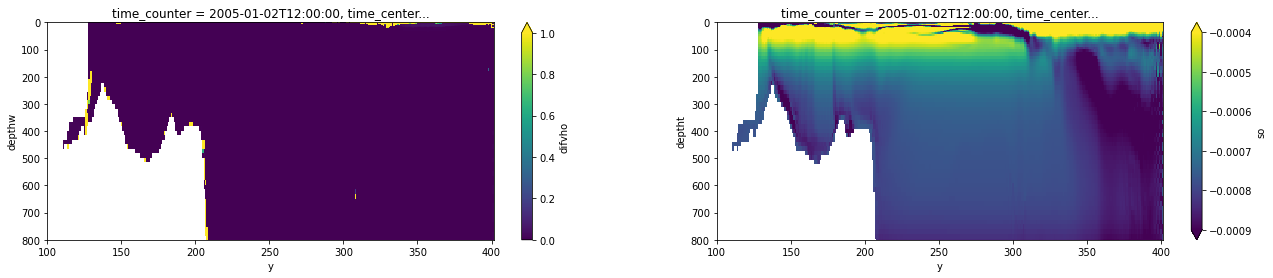

In [38]:
fig, ax = plt.subplots(1,2, figsize=(22, 4))
vdiff.isel(time_counter=1, x=100).plot(ax=ax[0], ylim=(800,0), xlim=(100,None), vmin=0, vmax=1)
N2.isel(time_counter=1, x=100).plot(ax=ax[1], ylim=(800,0), xlim=(100,None), vmin=-9e-4, vmax=-4e-4)

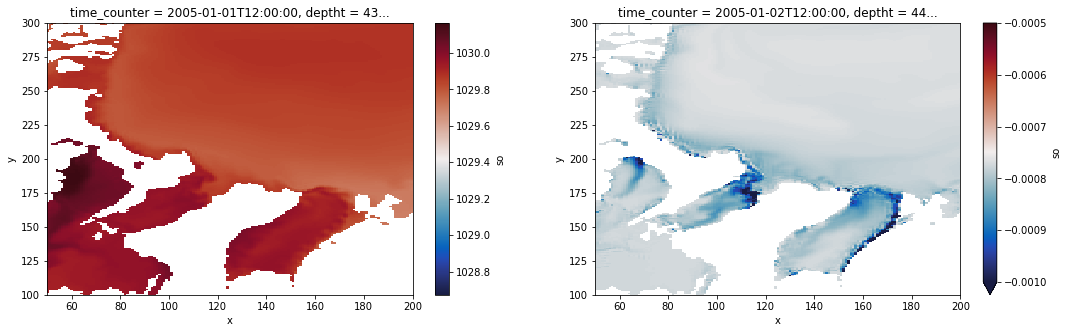

In [19]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
rho.isel(time_counter=0, deptht=46).plot(ax=ax[0], vmin=None, vmax=None, xlim=(50,200), ylim=(100,300), cmap=cmocean.cm.balance)
N2.isel(time_counter=1, deptht=46).plot(ax=ax[1], vmin=-10e-4, vmax=-5e-4, xlim=(50,200), ylim=(100,300), cmap=cmocean.cm.balance)

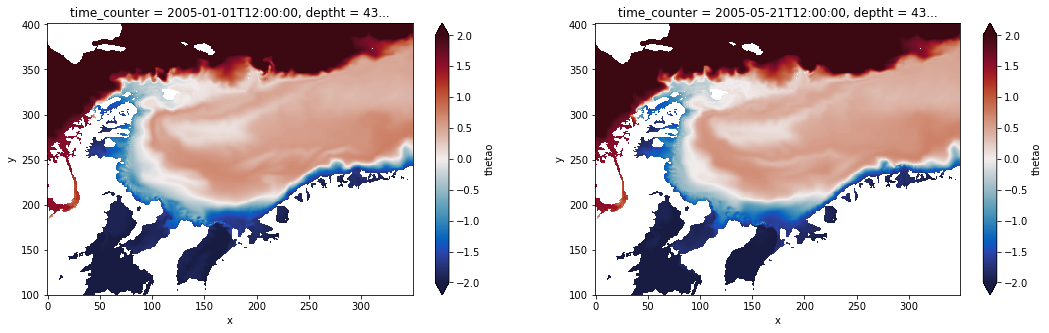

In [7]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
T.isel(time_counter=0, deptht=46).plot(ax=ax[0], vmin=-2, vmax=2, ylim=(100,None), cmap=cmocean.cm.balance)
T.isel(time_counter=140, deptht=46).plot(ax=ax[1], vmin=-2, vmax=2, ylim=(100,None), cmap=cmocean.cm.balance)

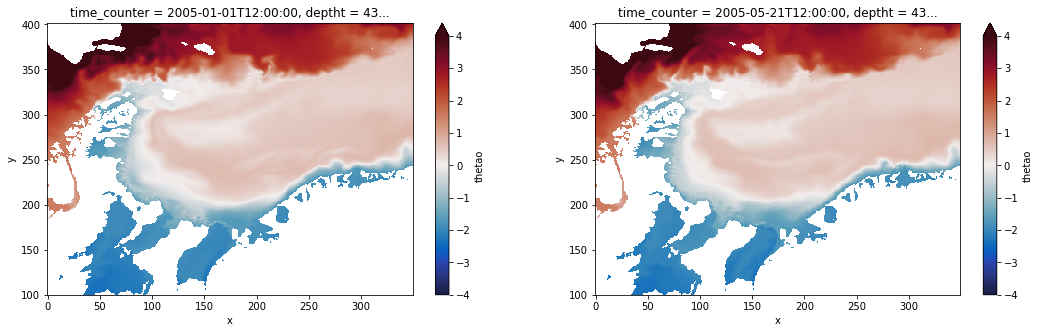

In [7]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
T.isel(time_counter=0, deptht=46).plot(ax=ax[0], vmin=-4, vmax=4, ylim=(100,None), cmap=cmocean.cm.balance)
T.isel(time_counter=140, deptht=46).plot(ax=ax[1], vmin=-4, vmax=4, ylim=(100,None), cmap=cmocean.cm.balance)

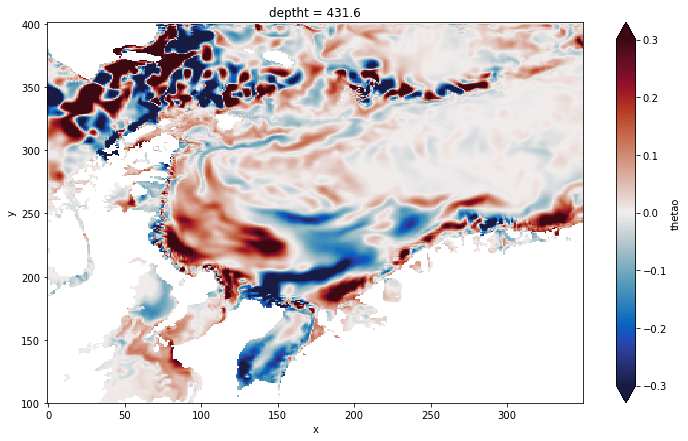

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
(T.isel(time_counter=140, deptht=46) - T.isel(time_counter=0, deptht=46)).plot(ax=ax, 
                                                                               vmin=-0.3, vmax=0.3, ylim=(100,None), cmap=cmocean.cm.balance)

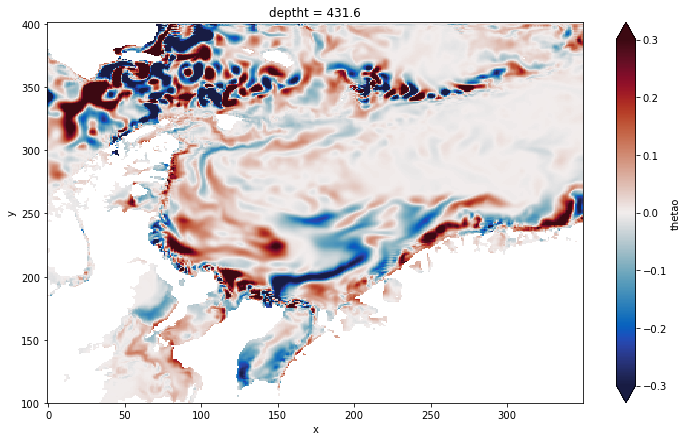

In [9]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
(T.isel(time_counter=80, deptht=46) - T.isel(time_counter=0, deptht=46)).plot(ax=ax, 
                                                                               vmin=-0.3, vmax=0.3, ylim=(100,None), cmap=cmocean.cm.balance)

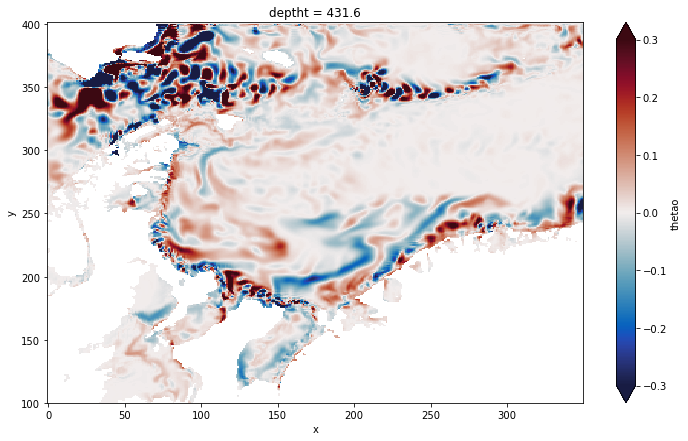

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
(T.isel(time_counter=40, deptht=46) - T.isel(time_counter=0, deptht=46)).plot(ax=ax, 
                                                                               vmin=-0.3, vmax=0.3, ylim=(100,None), cmap=cmocean.cm.balance)

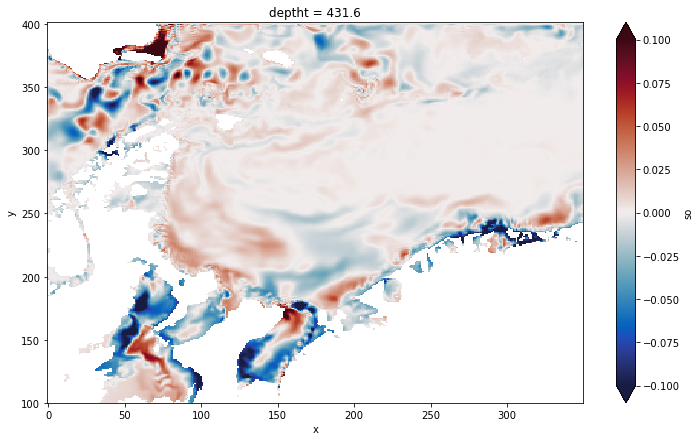

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
(S.isel(time_counter=140, deptht=46) - S.isel(time_counter=0, deptht=46)).plot(ax=ax, 
                                                                               vmin=-0.1, vmax=0.1, ylim=(100,None), cmap=cmocean.cm.balance)

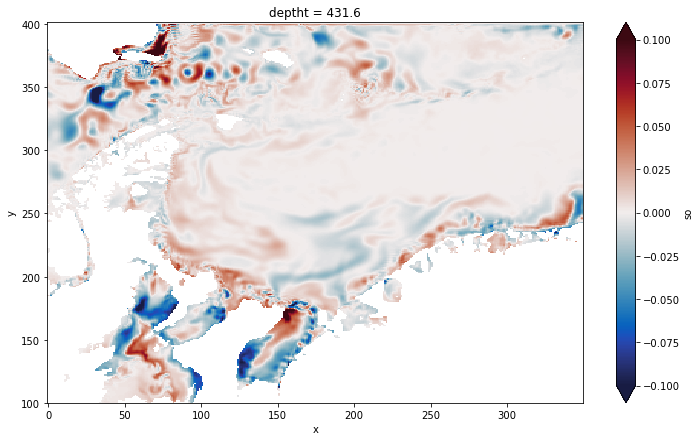

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
(S.isel(time_counter=80, deptht=46) - S.isel(time_counter=0, deptht=46)).plot(ax=ax, 
                                                                               vmin=-0.1, vmax=0.1, ylim=(100,None), cmap=cmocean.cm.balance)

(34.5, 35.0)

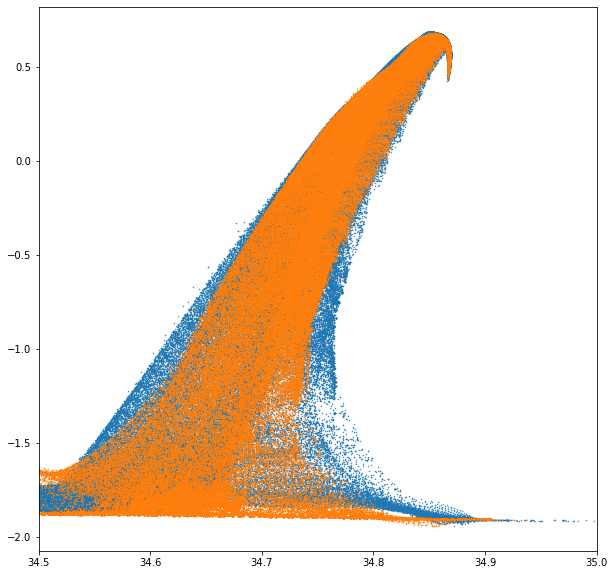

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(S.isel(time_counter=0, deptht=slice(0,85)), T.isel(time_counter=0, deptht=slice(0,85)), s=0.2)
ax.scatter(S.isel(time_counter=-1, deptht=slice(0,85)), T.isel(time_counter=-1, deptht=slice(0,85)), s=0.2)
ax.set_xlim(34.5, 35.0)